Prueva a realizar convoluciones para dar más realismo a la simulación y ver como afecta. Además considera también la humedad fraccional como un campo aleatorio. ¿Cual debería ser la desviación estandar de la humedad?

https://en.wikipedia.org/wiki/Density_of_air#Humid_air

https://en.wikipedia.org/wiki/Gas_constant#Specific_gas_constant

In [3]:
import fdtd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

from ciddor_air import n

In [ ]:
# Todo en una celda
def set_up_grid(longitud_onda:float, T=25, h=0.2):
	# para longitud de onda: debe ser en  metros -> el spacing debe ser 10 veces menor que la longitud de onda para tener estabilidad
	R_esp = 287.052874 # Constante de gas ideal específica del aire J⋅kg−1⋅K−1
	rho_aire = 1.225 # kg/m3
	pressure = rho_aire*R_esp*(273 + T)
	perm = n(longitud_onda*1e6, T, pressure, h, 350)**2
	grid = fdtd.Grid(
		shape = (400, 200, 1), #   Dando el último valor como uno se crea una grid de dos dimensiones
		permittivity=perm,
		grid_spacing=longitud_onda*0.1
	)

	# Añadimos una fuente con perfil gaussiano
	# tamaño_y = grid.shape[1]*2//4
	# offset_y = grid.shape[1]//4
	tamaño_y = grid.shape[1]*1//10
	offset_y = grid.shape[1]*9//20

	grid[grid.shape[0]-40, offset_y:offset_y+tamaño_y, 0] = fdtd.LineSource(
		period = longitud_onda / (3e8), name="Fuente", amplitude=2.
	) # 20:80
	# Añadimos un detector
	grid[20, :, 0] = fdtd.LineDetector(name="detector")

	# x boundaries
	grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
	grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

	# y boundaries
	grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
	grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")
	
	return grid, perm

def put_patch_temperature(grid, mean_T=25, std_T=1, mean_h=0.2, std_h=0.01, kernel=np.array([[[1, 0], [0, 0]], [[0, 0], [0, 1]]])):
	"""
	Pon un patch en la grid. Versión que genera uno donde la temperatura es un campo aleatorio basado en una gausiana
	"""
	# Tamaño en x: fracción del dominio
	tamaño_x = grid.shape[0]*2//3
	# Tamaño en y: fracción del dominio
	tamaño_y = grid.shape[1]*4//6
	# Temperaturas en grados centigrados
	T_patch = np.random.normal(mean_T, std_T, (tamaño_x, tamaño_y, 1))
	# Humedad fraccional de 0 a 1
	h_patch = np.random.normal(mean_h, std_h, (tamaño_x, tamaño_y, 1))

	print("T", np.mean(T_patch), np.std(T_patch), T_patch.shape)
	print("H", np.mean(h_patch), np.std(h_patch), h_patch.shape)
	# Realiza una convolución para suavizar los campos
	
	T_patch = sc.signal.convolve(T_patch, kernel, mode="same") # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html
	h_patch = sc.signal.convolve(h_patch, kernel, mode="same")
	print("T", np.mean(T_patch), np.std(T_patch), T_patch.shape)
	print("H", np.mean(h_patch), np.std(h_patch), h_patch.shape)

	R_esp = 287.052874 # Constante de gas ideal específica del aire J⋅kg−1⋅K−1
	rho_aire = 1.225 # kg/m3
	pressure = rho_aire*R_esp*(273 + T_patch) # Simple aproximación, no tiene en cuenta los cambios de humedad 
	patch = n(longitud_onda*1e6, T_patch, pressure, h_patch, 350)**2 # Recuerda que longitud de onda es en micrometros
	print("P", np.mean(pressure), np.std(pressure))
	print("epsilon", np.mean(patch), np.std(patch), patch.shape)

	# Pon el patch
	offset_x = grid.shape[0]//10
	offset_y = grid.shape[1]//6
	grid[offset_x:offset_x+tamaño_x, offset_y:offset_y+tamaño_y, 0] = fdtd.Object(permittivity=patch, name="Aire turbulento")

	plt.imshow(patch)
	plt.show()
	return patch

def get_average_detector_data(grid, t_index_1, t_index_2, kind="E"):
	"""Toma el promedio de E^2 (no el cuadrado del promedio) de lo que llega al detector de la grid.
	El promedio es lo que detecta entre los tiempos t_index_1, t_index_2. Debes dar los tiempos como indices"""
	valores = grid.detector.detector_values()[kind]
	valores = np.array(valores)

	tol = 1e-10
	valores = np.where(np.abs(valores) > tol, valores, 0.0)

	magnitud_detector_E1 = np.einsum("ijk,ijk->ij", valores, valores)[t_index_1:t_index_2]

	return np.average(magnitud_detector_E1, axis=0)


In [39]:
n(2, np.array([25, 25, 30, 30]), 100_000, np.array([0.2, 0.2, 0.0, 0.0]), 300)

array([1.00026012, 1.00026012, 1.00025604, 1.00025604])

In [40]:
def gaussian_kernel_nd(shape, sigma):
    """
    Create an n-dimensional Gaussian kernel.
    
    Parameters:
    shape: tuple of ints - shape of the kernel (e.g., (5, 5) for 2D, (5, 5, 5) for 3D)
    sigma: float or tuple - standard deviation(s) for each dimension
    """
    # Create a delta function at the center
    kernel = np.zeros(shape)
    center = tuple(s // 2 for s in shape)
    kernel[center] = 1.0
    
    # Apply Gaussian filter to create the kernel
    return sc.ndimage.gaussian_filter(kernel, sigma=sigma)

def gaussian_laplace_kernel_nd(shape, sigma):
    # Create a delta function at the center
    kernel = np.zeros(shape)
    center = tuple(s // 2 for s in shape)
    kernel[center] = 1.0
    
    # Apply Gaussian filter to create the kernel
    return sc.ndimage.gaussian_laplace(kernel, sigma=sigma)

T 30.006088924933827 20.957320683599363 (266, 133, 1)
H 0.49763725180686796 0.2978068671453532 (266, 133, 1)
T 29.634884698480793 6.246586552878566 (266, 133, 1)
H 0.49123808241706296 0.09282930186317166 (266, 133, 1)
P 106418.46144606298 2196.548262799593
n 1.0005441500841912 6.170042897882912e-07 (266, 133, 1)


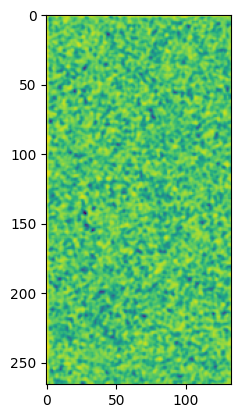

100%|██████████| 800/800 [00:06<00:00, 119.18it/s]


In [42]:
longitud_onda = 2e-6

tiempo_total = 800

T, h = 30, 0.3
std_T, std_h = 7, 0.05

grid, current_perm = set_up_grid(longitud_onda, T=T, h=h)

# Ningun blur
# put_patch_temperature(grid, mean_T=T, std_T=std_T, mean_h=h, std_h=std_h)

# Box blur simple
# b = 10 # dimension del boxblur
# kernel = (1/b**2)*np.ones((b, b, 1))

# put_patch_temperature(grid, T, std_T*b, mean_h=h, std_h=std_h*b, kernel=kernel) # Multiplicamos por la dimensión del boxblur (relación empirica) para obtener la desviación estandar deseada (7 en este caso)

# kernel = np.array([
#     [[-1, -2, -1]], 
#     [[0, 0, 0]],
#     [[1, 2, 1]]
# ]) # No funciona, arruina la media y la desviación estandard

# put_patch_temperature(grid, 30, 7*b, mean_h=0.5, std_h=0.1*b, kernel=kernel)

b = 10
std_kernel = 1 # (1, 2, 1)
kernel = gaussian_kernel_nd((b, b, 1), std_kernel)

current_patch = put_patch_temperature(grid, 30, 7*3, mean_h=0.5, std_h=0.1*3, kernel=kernel)

kernel = gaussian_laplace_kernel_nd((b, b, 1), std_kernel)

grid.run(total_time=tiempo_total)

grid2, _ = set_up_grid(longitud_onda, T=T, h=h)
grid2.run(total_time=tiempo_total) 

C:\Users\villa\AppData\Local\Temp\ipykernel_15096\3607597262.py:16: RuntimeWarning: invalid value encountered in divide
  r = np.where(np.abs(m2) > tol, m1/m2, 0.0)


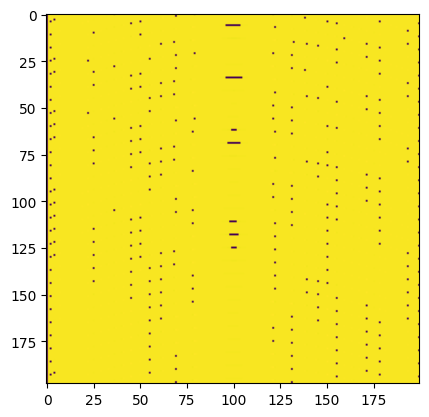

In [43]:
valores = grid.detector.detector_values()["E"]
valores = np.array(valores)
magnitud_detector_E1 = np.einsum("ijk,ijk->ij", valores, valores)

valores2 = grid2.detector.detector_values()["E"]
valores2 = np.array(valores2)
magnitud_detector_E2 = np.einsum("ijk,ijk->ij", valores2, valores2)

m1 = magnitud_detector_E1[600:][1:-1]
m2 = magnitud_detector_E2[600:][1:-1]

tol = 1e-7

m1 = np.where(np.abs(m1) > tol, m1, 0.0)

r = np.where(np.abs(m2) > tol, m1/m2, 0.0)

plt.imshow(r) # Arriba = pasado
plt.show()

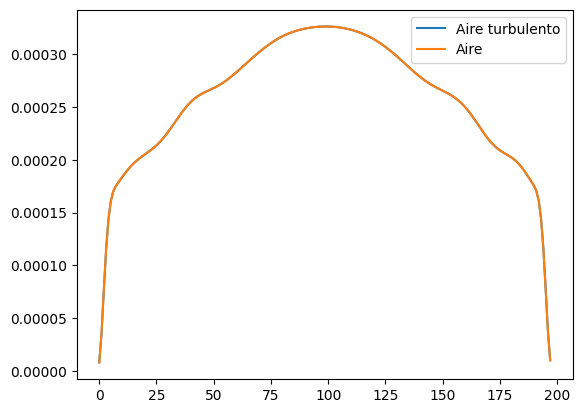

In [44]:
# Tamaño de la ventana con la que hacer el promedio
tamaño = grid.sources[0].period*10 # Debe ser un orden de magnitud mayor que el periodo de la onda
offset = -20

inital = - tamaño - offset
final = offset

magnitud_detector_E1 = get_average_detector_data(grid, inital, final)[1:-1]
magnitud_detector_E2 = get_average_detector_data(grid2, inital, final)[1:-1]

#plt.figure(figsize=(12, 10))

plt.plot(magnitud_detector_E1, label="Aire turbulento")
plt.plot(magnitud_detector_E2, label="Aire")

# plt.plot(magnitud_detector_E1/magnitud_detector_E2.max(), label="Aire turbulento")
# plt.plot(magnitud_detector_E2/magnitud_detector_E2.max(), label="Aire")
plt.legend()
plt.show()

0.0002554394440180584 0.0002554396124024729 0.9999987083357457


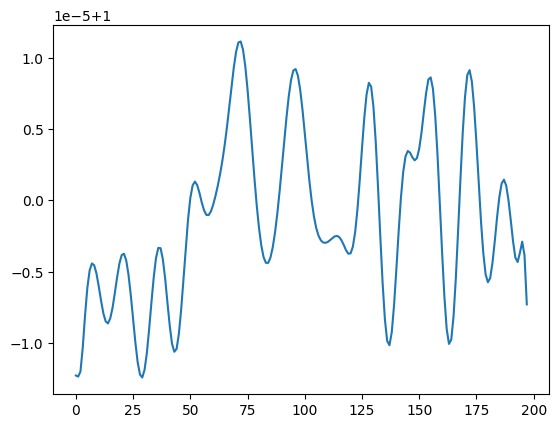

In [72]:
magnitud_detector_E1 = get_average_detector_data(grid, inital, final)[1:-1]
magnitud_detector_E2 = get_average_detector_data(grid2, inital, final)[1:-1]

# Dividiendo las dos cantidades, es posible abstraer las unidades del problema
# Se puede esperar que el ratio sea siempre menor o igual a uno, ya que los pequeños cambios del indice deben disipar algo de energía
r = magnitud_detector_E1/magnitud_detector_E2
print(np.mean(magnitud_detector_E1), np.mean(magnitud_detector_E2), np.mean(r)) # La diferencia de las medias es más pequeña que el ruido de la simulación
plt.plot(r)
# a = magnitud_detector_E1/magnitud_detector_E1.max()
# b = magnitud_detector_E2/magnitud_detector_E1.max()
# plt.plot(a/b)
# plt.hlines(y=0.0, xmin=0, xmax=200, color="black", linestyle="--")
plt.show()

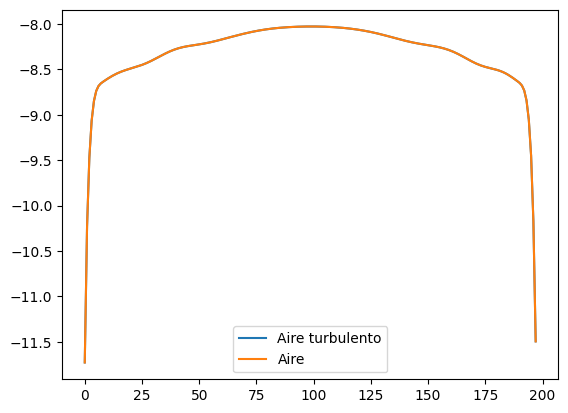

In [46]:
# plt.plot(magnitud_detector_E1, label="Aire turbulento")
# plt.plot(magnitud_detector_E2, label="Aire")
log_d1 = np.log(magnitud_detector_E1)
log_d2 = np.log(magnitud_detector_E2)
plt.plot(log_d1, label="Aire turbulento")
plt.plot(log_d2, label="Aire")
# plt.ylim((1.0e-4, 1.3e-4))
# plt.xlim((100, 200))
plt.legend()
plt.show()

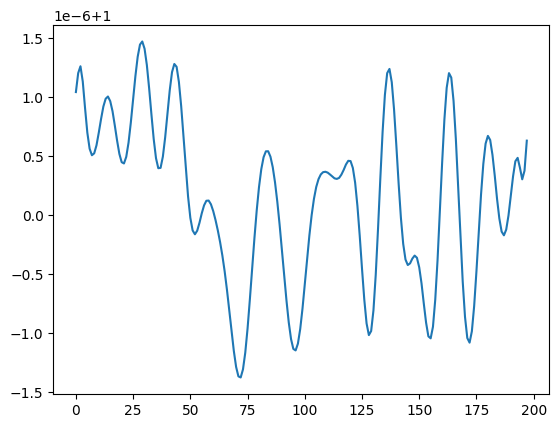

In [47]:
plt.plot(log_d1/log_d2)
plt.show()

Cálculos de energía.

La densidad de energía del campo electromagnético es: 

$$
    u = \frac{1}{2} \left(\epsilon E^2 + \frac{1}{\mu} B\right)
$$

Teniendo en cuenta que en general $c = \frac{1}{\sqrt{\epsilon_0 \mu_0}}$ y en el caso considerado $\mu = \mu_0$, se puede simplificar la expresión:

$$
    u = \frac{1}{2} \left(\epsilon E^2 + \frac{1}{\mu} B\right) = \frac{1}{2} \epsilon \left(\epsilon_r E^2 + \frac{1}{\epsilon_0\mu_0} B\right) 
$$

Por otro lado en términos de $\vec H$:

$$
    u = \frac{1}{2} \left(\epsilon E^2 + \mu H^2 \right) = \frac{1}{2} \left(\epsilon E^2 + \mu_0 H^2 \right) = \frac{1}{2} \epsilon_0 \left(\epsilon_r E^2 +  \frac{1}{\eta^2_0} H^2 \right)
$$


0.00025617844502059614 0.00025617876939600147 0.9999982578418015


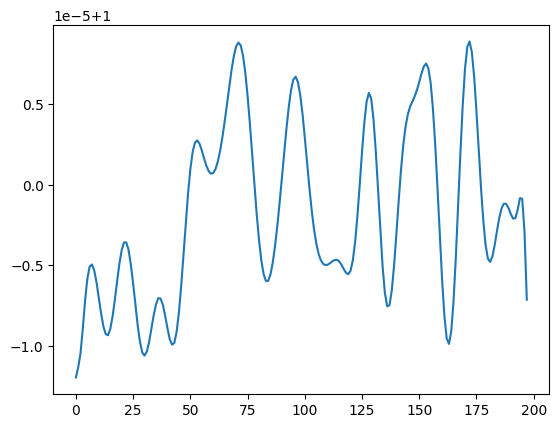

In [48]:
magnitud_detector_H1 = get_average_detector_data(grid, inital, final, kind="H")[1:-1]
magnitud_detector_H2 = get_average_detector_data(grid2, inital, final, kind="H")[1:-1]

r = magnitud_detector_H1/magnitud_detector_H2
print(np.mean(magnitud_detector_H1), np.mean(magnitud_detector_H2), np.mean(r))
plt.plot(r)

# plt.hlines(y=0.0, xmin=0, xmax=200, color="black", linestyle="--")
plt.show()

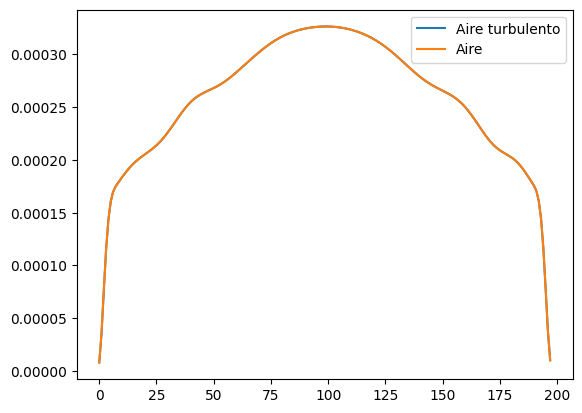

In [51]:
# Impedancia del vacío en ohmnios
imp_0 = 377.0

densidad1 = current_perm*get_average_detector_data(grid, inital, final, kind="E")[1:-1] + (1/imp_0**2)*get_average_detector_data(grid, inital, final, kind="H")[1:-1]
densidad2 = current_perm*get_average_detector_data(grid2, inital, final, kind="E")[1:-1] + (1/imp_0**2)*get_average_detector_data(grid2, inital, final, kind="H")[1:-1]

plt.plot(densidad1, label="Aire turbulento")
plt.plot(densidad2, label="Aire")

plt.legend()
plt.show()

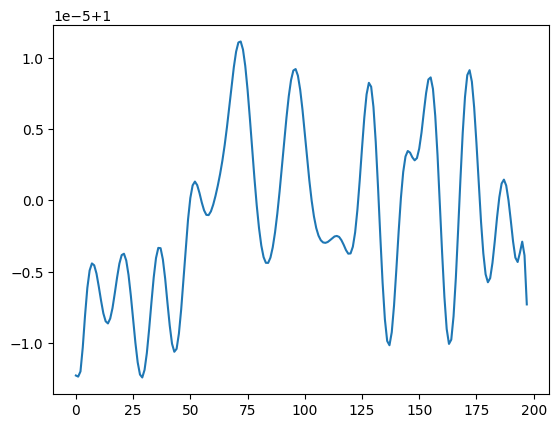

In [53]:
plt.plot(densidad1/densidad2)
plt.show()

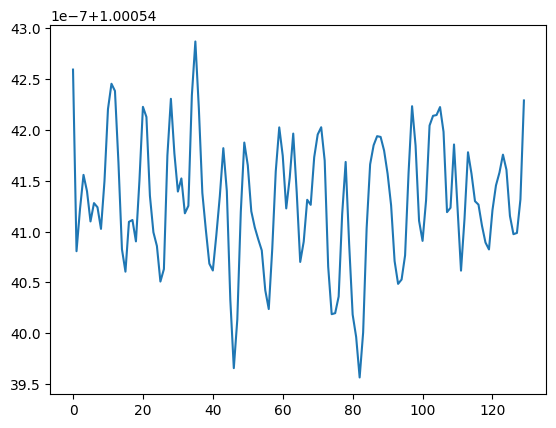

In [71]:
plt.plot(np.average(current_patch, axis=0)[2:-1])
plt.show()